# Explore population outbreaks in Fringilla insect data 

Due to high number of missing values, this line of research focusses on the years from 1998 to 2020.

In [ ]:
'''
NOTE:
- it's reasonable to also analyse the climate prior (up to a year or so) 
  to outbreaks
- I still have to decide on a suitable period of time to summarise the daily
  counts
TODO:
- Why isn't V. cardui included in the seasonal mean pattern plot?
- Properly comment this notebook!
''' 

In [1]:
# import libraries
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pickle as pkl
sns.set_theme(
    style="darkgrid",
    color_codes=True,
    palette='Dark2',
)

In [2]:
pkl_files = ['species.pkl', 'species_long.pkl', 'species_summed.pkl']

# define import function
def import_pickled_data():
    dummy = []
    for file in pkl_files:
        with open('../../data/'+file, 'rb') as f:
            dummy.append(pkl.load(f))
    return dummy

species, species_long, species_summed = import_pickled_data()

In [3]:
# get data into tidy form!
# i.e., single dataframe with variables as columns and single observations as rows

sheets = ['Vanessa atalanta', 'Vanessa cardui', 'Inachis io', 'Issoria lathonia', 'Aglais urticae',
          'Aporia crataegi', 'Apatura ilia', 'Aphantopus hyperanthus', 'Araschnia levana', 'Nymphalis antiopa',
          'Nymphalis polychloros', 'Nymphalis xanthomelas', 'Papilio machaon', 'Polygonia c-album', 'Pararge aegeria']

all_species = pd.DataFrame()
for s in sheets:
    df = species_summed[s]
    df['species'] = s # add species column
    df = df[['species', 'datetime', 'count', 'Temp', 'Wind', 'Cloud']] # select columns
    all_species = pd.concat([all_species, df]) # put final df together

In [4]:
# data processing...

# rename columns
all_species.rename(
    columns={'Temp': 'tmp', 'Wind': 'wind', 'Cloud':'cloud'}, 
    inplace=True
)

# specify time period (1998-2020)
# use datetime attribute "dt" to access the datetime components!
all_species = all_species[all_species['datetime'].dt.year >= 1998]

# and reset index
all_species.reset_index(drop=True, inplace=True)

# add year, month, day column
all_species['year'] = all_species['datetime'].dt.year
all_species['month'] = all_species['datetime'].dt.month
all_species['day'] = all_species['datetime'].dt.day

display(all_species)

,species,datetime,count,tmp,wind,cloud,year,month,day
0,Vanessa atalanta,1998-04-01,NaN,NaN,NaN,NaN,1998,4,1
1,Vanessa atalanta,1998-04-02,NaN,NaN,NaN,NaN,1998,4,2
2,Vanessa atalanta,1998-04-03,NaN,NaN,NaN,NaN,1998,4,3
3,Vanessa atalanta,1998-04-04,NaN,NaN,NaN,NaN,1998,4,4
4,Vanessa atalanta,1998-04-05,NaN,NaN,NaN,NaN,1998,4,5
...,...,...,...,...,...,...,...,...,...
74170,Pararge aegeria,2020-10-28,NaN,NaN,NaN,NaN,2020,10,28
74171,Pararge aegeria,2020-10-29,NaN,NaN,NaN,NaN,2020,10,29
74172,Pararge aegeria,2020-10-30,NaN,NaN,NaN,NaN,2020,10,30
74173,Pararge aegeria,2020-10-31,NaN,NaN,NaN,NaN,2020,10,31


### Abundance index (to classify outbreaks)

To quantify an outbreak, we compute the derivation from the **median** and take the logarithm to adjust for high index values. As the index can be negative, we use the logarithm as follows:

![logarithm](https://i.stack.imgur.com/xnYkb.png)

**Note**: Instead of the natural logarithm, we use the logarithm of base 10.

In [5]:
def mylog(x):
    if x > 0:
        log = np.log10(x)
    elif x < 0:
        log = np.log10(x*-1)*-1
    elif x == 0:
        log = 0
    return log

In [6]:
# sum up counts in each year
outbreaks = all_species.groupby(['species', 'year'], as_index=False)['count'].sum()

# compute total average count (across all years)
avg_count = outbreaks.groupby(['species'])['count'].median()
# https://stackoverflow.com/questions/62490392/how-to-apply-log-on-negative-values-based-upon-some-conditions-in-python

# add average count to df
outbreaks = outbreaks.set_index(['species'])
outbreaks['avg'] = avg_count
outbreaks = outbreaks.reset_index()

# computing outbreak index with zero reflecting the total average count
outbreaks['index'] = outbreaks['count'] - outbreaks['avg']
outbreaks['log index'] = outbreaks['index'].apply(mylog)

display(outbreaks)

,species,year,count,avg,index,log index
0,Aglais urticae,1998,2.0,15.0,-13.0,-1.113943
1,Aglais urticae,1999,1.0,15.0,-14.0,-1.146128
2,Aglais urticae,2000,2.0,15.0,-13.0,-1.113943
3,Aglais urticae,2001,8.0,15.0,-7.0,-0.845098
4,Aglais urticae,2002,77.0,15.0,62.0,1.792392
...,...,...,...,...,...,...
340,Vanessa cardui,2016,39.0,14.0,25.0,1.397940
341,Vanessa cardui,2017,6.0,14.0,-8.0,-0.903090
342,Vanessa cardui,2018,11.0,14.0,-3.0,-0.477121
343,Vanessa cardui,2019,3270.0,14.0,3256.0,3.512684


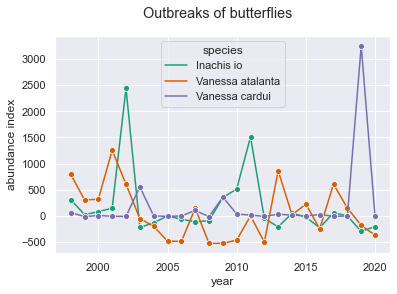

In [7]:
# plotting
size = 3500
data = outbreaks[
    (outbreaks['species'] == 'Vanessa atalanta') | 
    (outbreaks['species'] == 'Vanessa cardui') |
    (outbreaks['species'] == 'Inachis io')
]

fig, ax = plt.subplots()
sns.lineplot(data=data, x='year', y='index', hue='species', marker='o', ax=ax)
ax.set_ylabel('abundance index')
#ax.set_ylim(top=size, bottom=-size)
#ax.set_yscale('symlog')
fig.suptitle('Outbreaks of butterflies')
fig.savefig('../figs/kaliningrad/outbreaks_log-index_per-year.png', 
            dpi=600, bbox_inches='tight')

### Mean seasonal pattern (to temporally locate outbreaks)

`count_sum` = accumulated count in specific time interval </br>
`all_species_mean` = dataframe with mean count per day for all years

In [8]:
# computing accumulated count for fixed number of observations (i.e., days)
moving_window_size = 21

accumulated_counts = all_species.groupby(['species', 'year']).rolling(
    window=moving_window_size,
    min_periods=1,
    center=True,
)['count'].sum().sort_index(level=2) # somehow, the order of count values is
                                     # changed, hence, use index to re-order 
                                     # the Pandas series!

all_species['count_sum'] = accumulated_counts.values # Pandas series has index,
                                                     # hence, just use values!
all_species

,species,datetime,count,tmp,wind,cloud,year,month,day,count_sum
0,Vanessa atalanta,1998-04-01,NaN,NaN,NaN,NaN,1998,4,1,0.0
1,Vanessa atalanta,1998-04-02,NaN,NaN,NaN,NaN,1998,4,2,0.0
2,Vanessa atalanta,1998-04-03,NaN,NaN,NaN,NaN,1998,4,3,0.0
3,Vanessa atalanta,1998-04-04,NaN,NaN,NaN,NaN,1998,4,4,0.0
4,Vanessa atalanta,1998-04-05,NaN,NaN,NaN,NaN,1998,4,5,0.0
...,...,...,...,...,...,...,...,...,...,...
74170,Pararge aegeria,2020-10-28,NaN,NaN,NaN,NaN,2020,10,28,0.0
74171,Pararge aegeria,2020-10-29,NaN,NaN,NaN,NaN,2020,10,29,0.0
74172,Pararge aegeria,2020-10-30,NaN,NaN,NaN,NaN,2020,10,30,0.0
74173,Pararge aegeria,2020-10-31,NaN,NaN,NaN,NaN,2020,10,31,0.0


In [9]:
# computing mean count per day (i.e., per fixed number of observations)
all_species_mean = all_species.groupby(['species', 'month', 'day'],
                   as_index=False)['count_sum'].mean()

# the quick & dirty way to get a datetime object column, which is needed for
# plotting soon
all_species_mean['year'] = 1900
all_species_mean['datetime'] = pd.to_datetime(all_species_mean[['year', 'month', 'day']])
all_species_mean = all_species_mean.drop('year', axis=1)
all_species_mean.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3225 entries, 0 to 3224
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   species    3225 non-null   object        
 1   month      3225 non-null   int64         
 2   day        3225 non-null   int64         
 3   count_sum  3225 non-null   float64       
 4   datetime   3225 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 126.1+ KB


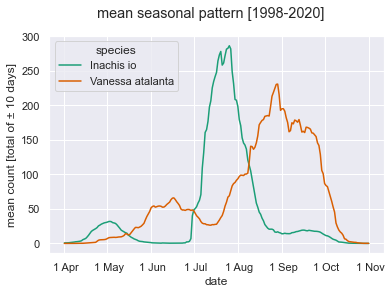

In [10]:
# plotting
data = all_species_mean[
    (all_species_mean['species'] == 'Vanessa atalanta') | 
    #(all_species_mean['species'] == 'Vanessa cardui') |
    (all_species_mean['species'] == 'Inachis io')
]

fig, ax = plt.subplots()
sns.lineplot(data=data, x='datetime', y='count_sum', hue='species', ax=ax)

# Define the date format -----------------
from matplotlib.dates import DateFormatter
date_form = DateFormatter("%e %b")
ax.xaxis.set_major_formatter(date_form)
#fig.autofmt_xdate()
# ----------------------------------------

ax.set_ylabel(f'mean count [total of ± {int((moving_window_size-1)/2)} days]')
ax.set_xlabel('date')
fig.suptitle('mean seasonal pattern [1998-2020]')
fig.savefig('../figs/kaliningrad/outbreaks_mean-seasonal-pattern.png', 
            dpi=600, bbox_inches='tight')

### 2019 vanessa cardui outbreak 

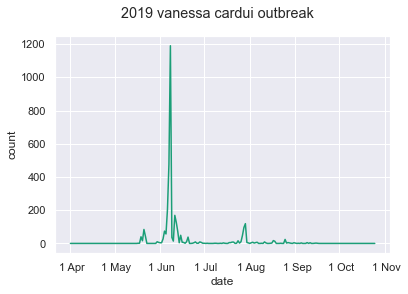

In [14]:
data = all_species[
    (all_species['species'] == 'Vanessa cardui') &
    (all_species['year'] == 2019)
]

fig, ax = plt.subplots()
sns.lineplot(data=data, x='datetime', y='count', ax=ax)

# Define the date format -----------------
date_form = DateFormatter("%e %b")
ax.xaxis.set_major_formatter(date_form)
# ----------------------------------------

#ax.set_ylabel(f'count [total of ± {int((moving_window_size-1)/2)} days]')
ax.set_xlabel('date')
fig.suptitle('2019 vanessa cardui outbreak')
fig.savefig('../figs/kaliningrad/outbreaks_v-cardui_2019.png', 
            dpi=600, bbox_inches='tight')

### 2002 inachis io outbreak

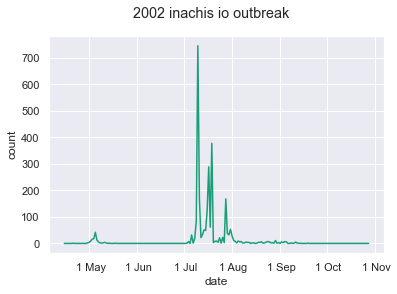

In [12]:
data = all_species[
    (all_species['species'] == 'Inachis io') &
    (all_species['year'] == 2002)
]

fig, ax = plt.subplots()
sns.lineplot(data=data, x='datetime', y='count', ax=ax)

# Define the date format -----------------
date_form = DateFormatter("%e %b")
ax.xaxis.set_major_formatter(date_form)
# ----------------------------------------

#ax.set_ylabel(f'count [total of ± {int((moving_window_size-1)/2)} days]')
ax.set_xlabel('date')
fig.suptitle('2002 inachis io outbreak')
fig.savefig('../figs/kaliningrad/outbreaks_i-io_2002.png', 
            dpi=600, bbox_inches='tight')